# Лабораторная работа №7 "Рекуррентные нейронные сети для анализа текста"

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

from google.colab import drive

import json
import pathlib
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/7/'
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Задание 1.
Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.

In [55]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xfz aclImdb_v1.tar.gz

--2020-05-07 17:27:03--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  69.1MB/s    in 1.2s    

2020-05-07 17:27:04 (69.1 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [ ]:
!tar xfz aclImdb_v1.tar.gz

In [ ]:
BATCH_SIZE = 128
NUM_WORDS = 10000
MAX_REVIEW_LEN = 200

In [ ]:
def load_data(folder):
    labels_mapping = {'pos': 1, 'neg': 0}
    data = {'reviews': [], 'labels': []}
    for label_folder in labels_mapping.keys():
        data_dir = pathlib.Path(f'aclImdb/{folder}/{label_folder}')
        for path in data_dir.glob('*.txt'):
            with path.open('r') as f:
                data['reviews'].append(f.read())
                data['labels'].append(labels_mapping[label_folder])
    
    return pd.DataFrame(data)

In [90]:
train_data = load_data('train')
train_data

reviews  labels
0      I'll tell you a tale of the summer of 1994. A ...       1
1      As a disclaimer, I've seen the movie 5-6 times...       1
2      The greatest games of Kasparov or Fischer can ...       1
3      I was not really a big fan of Star Trek until ...       1
4      I couldn't agree more with Nomad 7's and I A H...       1
...                                                  ...     ...
24995  Some people seem to think this was the worst m...       0
24996  Simply not the quality I expected from Morris ...       0
24997  one of the worst films i have seen to date. Pa...       0
24998  Just once I'd like to see a version of Beowulf...       0
24999  A warning to you not to be seduced by the name...       0

[25000 rows x 2 columns]

Создадим объект токенизатора, ограничив количество слов, а также передадим токен для слов, которые не будут найдены в словаре.

In [ ]:
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<UNK>')

In [92]:
tokenizer.fit_on_texts(train_data['reviews'])
tokenizer.word_index

{'<UNK>': 1,
 'the': 2,
 'and': 3,
 'a': 4,
 'of': 5,
 'to': 6,
 'is': 7,
 'br': 8,
 'in': 9,
 'it': 10,
 'i': 11,
 'this': 12,
 'that': 13,
 'was': 14,
 'as': 15,
 'for': 16,
 'with': 17,
 'movie': 18,
 'but': 19,
 'film': 20,
 'on': 21,
 'not': 22,
 'you': 23,
 'are': 24,
 'his': 25,
 'have': 26,
 'he': 27,
 'be': 28,
 'one': 29,
 'all': 30,
 'at': 31,
 'by': 32,
 'an': 33,
 'they': 34,
 'who': 35,
 'so': 36,
 'from': 37,
 'like': 38,
 'her': 39,
 'or': 40,
 'just': 41,
 'about': 42,
 "it's": 43,
 'out': 44,
 'if': 45,
 'has': 46,
 'some': 47,
 'there': 48,
 'what': 49,
 'good': 50,
 'more': 51,
 'when': 52,
 'very': 53,
 'up': 54,
 'no': 55,
 'time': 56,
 'she': 57,
 'even': 58,
 'my': 59,
 'would': 60,
 'which': 61,
 'only': 62,
 'story': 63,
 'really': 64,
 'see': 65,
 'their': 66,
 'had': 67,
 'can': 68,
 'were': 69,
 'me': 70,
 'well': 71,
 'than': 72,
 'we': 73,
 'much': 74,
 'been': 75,
 'bad': 76,
 'get': 77,
 'will': 78,
 'do': 79,
 'also': 80,
 'into': 81,
 'people': 82,
 '

In [ ]:
# make train data
train_sequences = tokenizer.texts_to_sequences(train_data['reviews'])
x_train = pad_sequences(train_sequences, maxlen=MAX_REVIEW_LEN)
y_train = train_data['labels'].to_numpy()

In [ ]:
# make test data
test_data = load_data('test')
test_sequences = tokenizer.texts_to_sequences(test_data['reviews'])
x_test = pad_sequences(test_sequences, maxlen=MAX_REVIEW_LEN)
y_test = test_data['labels'].to_numpy()

In [95]:
x_train[:3]

array([[2354,  363, 1231,   72,  296,   40,  696,  106,    3,   89,   82,
          90,   38,    6,  104,  230,   13,  932,   40,  270,   38,   71,
          22,   38,   33,  296,   20,  373, 2271, 6193,  397,  304,   36,
        1057,   54,    9,  110,  912,   13,   34, 1582, 1680,    5,   87,
           6,  374,    4,   50,   63,    3,  374,   10,   71,  838,   34,
         304,    6,  102,   13, 2162, 1004,  397,  366, 6042,  164,  140,
        1610,  144,  250,  257,   35, 3627,  193, 2271,  100,  259,  520,
          31,  312,   21,    2, 9655,  692,  615,   49,  144,  660,   42,
          43,  218,   38,    4,   90,   79,   12,    1, 2975,   44,   48,
        1195,    3, 2271,   20, 1185, 3900,   10,   44,    4,  194,   56,
         594,    8,    8,    9,    2, 4761,    3,    1,  188,   47,  106,
         139,   15, 1475,    1,  155,    3,    2,  527, 1145, 1477,    4,
        4518, 5121,   26, 1907,   12, 9261,    3, 1315,    6, 4519,   49,
         164,   96, 2271,  135, 2402, 

In [96]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (25000, 200)
y_train shape: (25000,)
x_test shape: (25000, 200)
y_test shape: (25000,)


Таким обрзом, все тексты превращаются в последовательности чисел (индексов) с помощью токенизатора. Если в тексте находится меньше слов, чем установленная длина вектора, то производится смещение слева.

Загружена обучающая и контрольная выборка.
Валидационная выборка будет выделена из обучающей в процессе обучения с помощью существующих инструментов keras.

### Задание 2.
Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?

In [ ]:
def show_history(history):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Попробуем использовать рекуррентную сеть со слоем GRU (Gated Recurrent Units) со 128 ячейками (юнитами). Этот слой имет 128 * 2 (потому двунаправленный) входов и 1 выход, который передаётся на слой бинарного классификатора.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               176640    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 1,176,897
Trainable params: 1,176,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
156/157 [============================>.] - ETA: 0s - loss: 0.5120 - accuracy: 0.7389
Epoch 00001: val_accuracy improved from -inf to 0.67040, saving model to rnn_text_first_model.h5
157/157 [==============================] - 9s 56ms/step - loss: 0.5118 - accuracy: 0.7390 - val_loss: 0.6037 - val_accuracy: 0.6704
Epoch 2/5
156/157 [============================>.

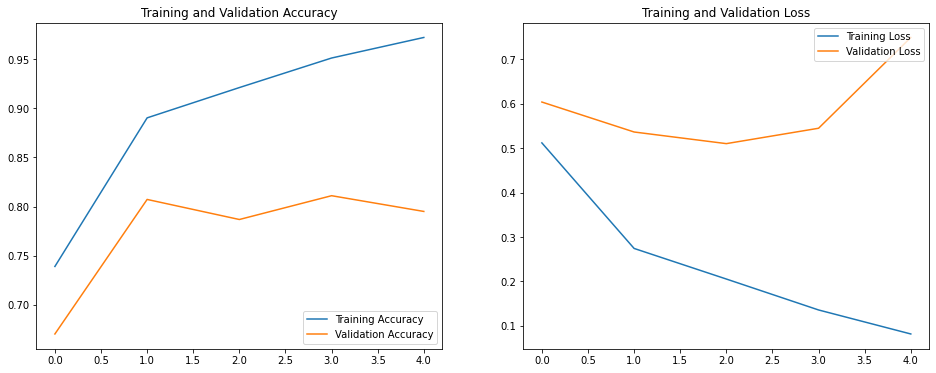

782/782 [==============================] - 7s 9ms/step - loss: 0.3960 - accuracy: 0.8512


[0.3960343897342682, 0.8512399792671204]

In [97]:
model = keras.models.Sequential([
    layers.Embedding(NUM_WORDS, 100, input_length=MAX_REVIEW_LEN),
    layers.Bidirectional(layers.GRU(128)),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

best_model_path = 'rnn_text_first_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history = model.fit(x_train, 
                    y_train, 
                    epochs=5,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback])

show_history(history)

test_model = keras.models.load_model(best_model_path)
test_model.evaluate(x_test, y_test, verbose=1)

Модель показала неплохую точность в 85.1% на контрольной выборке. Как можно заметить из графиков, эта модель быстро начинает переобучаться, поэтому наилучших результатов удаётся добиться на первых эпохах.

### Задание 3.
Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации?

Попробуем использовать индексы GloVe. Загрузим эмбеддинги с размерностью векторов 300, собранный на страницах википедии.

In [1]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2020-05-06 18:37:13--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-05-06 18:37:13--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-05-06 18:37:13--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
# !mv glove.840B.300d.zip /content/drive/'My Drive'/'Colab Notebooks'/7/

In [64]:
!unzip /content/drive/'My Drive'/'Colab Notebooks'/7/glove.840B.300d.zip -d /content

Archive:  /content/drive/My Drive/Colab Notebooks/7/glove.840B.300d.zip
  inflating: /content/glove.840B.300d.txt  


In [ ]:
embeddings_index = {}
with open("glove.840B.300d.txt", "r") as f:
    for line in f:
        values = line.split()
        try:
            word = values[0]
            embeddings_index[word] = np.asarray(values[1:], dtype=np.float32)
        except:
            pass

In [66]:
len(embeddings_index)

2195884

In [67]:
def convert_to_matrix(dictionary):
    embedding_matrix = np.zeros((NUM_WORDS, 300))
    for word, index in tokenizer.word_index.items():
        if index >= NUM_WORDS:
            continue

        vector = dictionary.get(word)
        if vector is not None:
            embedding_matrix[index][:] = vector[:]

    return embedding_matrix

embedding_matrix = convert_to_matrix(embeddings_index)
embedding_matrix.shape

(20000, 300)

Подключим готовые эмбеддинги к модели и заморозим их.

In [35]:
model = keras.models.Sequential([
    layers.Embedding(NUM_WORDS, 300, input_length=MAX_REVIEW_LEN, weights=[embedding_matrix], trainable=False),
    layers.Bidirectional(layers.GRU(128)),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,330,497
Trainable params: 330,497
Non-trainable params: 6,000,000
_________________________________________________________________


In [36]:
best_model_path = 'rnn_text_glove_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history = model.fit(x_train, 
                    y_train, 
                    epochs=5,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback])

Epoch 1/5
156/157 [============================>.] - ETA: 0s - loss: 0.4740 - accuracy: 0.7759
Epoch 00001: val_accuracy improved from -inf to 0.78060, saving model to rnn_text_glove_model.h5
157/157 [==============================] - 10s 62ms/step - loss: 0.4737 - accuracy: 0.7760 - val_loss: 0.5049 - val_accuracy: 0.7806
Epoch 2/5
156/157 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8632
Epoch 00002: val_accuracy did not improve from 0.78060
157/157 [==============================] - 9s 58ms/step - loss: 0.3223 - accuracy: 0.8633 - val_loss: 0.5777 - val_accuracy: 0.7558
Epoch 3/5
156/157 [============================>.] - ETA: 0s - loss: 0.2797 - accuracy: 0.8833
Epoch 00003: val_accuracy improved from 0.78060 to 0.84480, saving model to rnn_text_glove_model.h5
157/157 [==============================] - 9s 58ms/step - loss: 0.2797 - accuracy: 0.8834 - val_loss: 0.3658 - val_accuracy: 0.8448
Epoch 4/5
156/157 [============================>.] - ETA: 0s - los

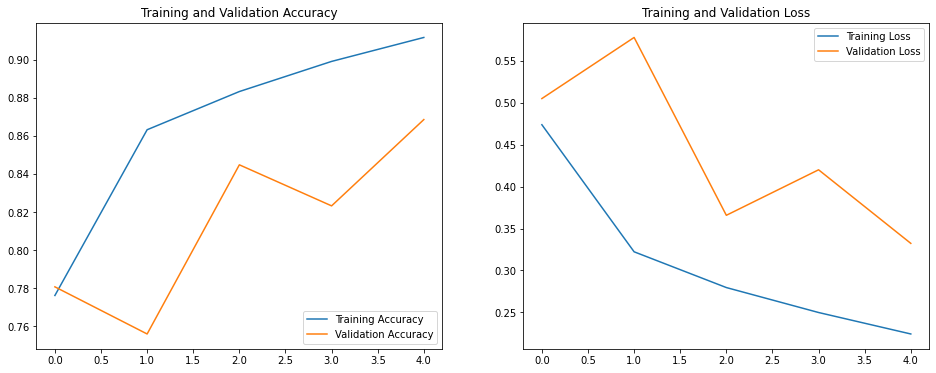

In [37]:
show_history(history)

In [38]:
test_model = keras.models.load_model(best_model_path)
test_model.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 9s 11ms/step - loss: 0.2759 - accuracy: 0.8864


[0.2759086489677429, 0.8864399790763855]

Как видим, использование GloVe увеличило значение точности классификатора на 3.5% и составило 88.6%. Также стоит заметить, что обучение проходило быстрее так как модели не надо было высчитывать параметры для эмбеддингов. К тому же переобучение теперь происходит не сразу, т.е. не с первых эпох.

### Задание 4.
Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?

Попробуем добавить один свёрточный одномерный слой с 250 картами признами, размер фильтра 5, и один полносвязный слой на 128 нейронов. Также, добавим регуляризацию дропаут с рейтом 20%. В качестве связки между свёрточным слоем и полносвязным выступает слой подвыборки, который извлекает максимальное значение с каждой карты признаков свёрточного слоя, таким образом превращая его в одномерный вектор.

In [43]:
model = keras.models.Sequential([
    layers.Embedding(NUM_WORDS, 300, input_length=MAX_REVIEW_LEN, weights=[embedding_matrix], trainable=False),
    layers.Conv1D(250, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 250)          375250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32128     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 6,407,507
Trainable params: 407,507
Non-trainable params: 6,000,000
______________________________________

In [44]:
best_model_path = 'rnn_text_extended_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history = model.fit(x_train, 
                    y_train, 
                    epochs=10,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback])

Epoch 1/10
155/157 [============================>.] - ETA: 0s - loss: 0.4164 - accuracy: 0.8048
Epoch 00001: val_accuracy improved from -inf to 0.75140, saving model to rnn_text_extended_model.h5
157/157 [==============================] - 5s 30ms/step - loss: 0.4154 - accuracy: 0.8054 - val_loss: 0.5116 - val_accuracy: 0.7514
Epoch 2/10
156/157 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.8918
Epoch 00002: val_accuracy improved from 0.75140 to 0.76680, saving model to rnn_text_extended_model.h5
157/157 [==============================] - 5s 29ms/step - loss: 0.2612 - accuracy: 0.8918 - val_loss: 0.5112 - val_accuracy: 0.7668
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9395
Epoch 00003: val_accuracy improved from 0.76680 to 0.76980, saving model to rnn_text_extended_model.h5
157/157 [==============================] - 5s 29ms/step - loss: 0.1678 - accuracy: 0.9395 - val_loss: 0.5605 - val_accuracy: 0.7698
Epoch 4/10

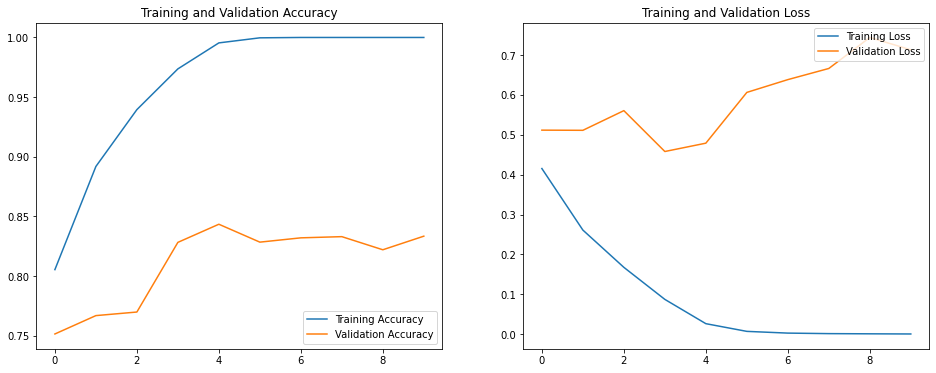

In [45]:
show_history(history)

In [46]:
test_model = keras.models.load_model(best_model_path)
test_model.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 4s 5ms/step - loss: 0.3562 - accuracy: 0.8783


[0.3562217652797699, 0.878279983997345]

К сожалению, это не улучшило точность классификатора, и результаты остались приблизительно на одном уровне. Точность составила 87.8%.

### Задание 5.
Используйте предобученную рекуррентную нейронную сеть (например, DeepMoji или что-то подобное).

Так как модель DeepMoji не присутствует в стандартных инструментах keras, то загружаем его со сторонних источников.

In [13]:
!git clone https://github.com/bfelbo/DeepMoji.git
!pip install emoji
!cd DeepMoji && python2 scripts/download_weights.py

Cloning into 'DeepMoji'...
remote: Enumerating objects: 281, done.
remote: Total 281 (delta 0), reused 0 (delta 0), pack-reused 281
Receiving objects: 100% (281/281), 110.54 MiB | 25.94 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Checking out files: 100% (66/66), done.
About to download the pretrained weights file from https://www.dropbox.com/s/xqarafsl6a8f9ny/deepmoji_weights.hdf5?dl=0#
The size of the file is roughly 85MB. Continue? [y/n]
y
Downloading...
Running system call: wget https://www.dropbox.com/s/xqarafsl6a8f9ny/deepmoji_weights.hdf5?dl=0# -O /content/DeepMoji/model/deepmoji_weights.hdf5
--2020-05-07 09:45:43--  https://www.dropbox.com/s/xqarafsl6a8f9ny/deepmoji_weights.hdf5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xqarafsl6a8f9ny/deepmoji_weights.hdf5 [foll

К сожалению, эта библиотека была написана на Python 2, поэтому необходимо произвести неоторые манипуляции для поддержки совестимости с нашей средой.

In [ ]:
к!sed -i -E "s|from tokenizer import tokenize|# from tokenizer import tokenize|" DeepMoji/deepmoji/finetuning.py
!sed -i -E "s|from sentence_tokenizer import SentenceTokenizer|# from sentence_tokenizer import SentenceTokenizer|" DeepMoji/deepmoji/finetuning.py
!sed -i -E "s|ur'|r'|g" /content/DeepMoji/deepmoji/tokenizer.py
!sed -i -E "s|ur\"|r\"|g" /content/DeepMoji/deepmoji/tokenizer.py

In [ ]:
import sys
sys.path.insert(1, "/content/DeepMoji")
sys.path.insert(1, "/content/DeepMoji/deepmoji")

In [ ]:
from deepmoji.model_def import deepmoji_transfer
from deepmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH, NB_TOKENS
from deepmoji.finetuning import finetune

Поскольку модель DeepMoji имеет свой словарь проиндексированных слов, а наши данные были построены на основе другого словаря, то необходимо произвести конвертацию данных в индексы словаря DeepMoji. Затем разобьём выборки на обучающую, валидационную и тестовую.

In [ ]:
with open(VOCAB_PATH, 'r') as f:
    deepmoji_vocab = json.load(f)

In [ ]:
def convert_data(data, old_vocab, new_vocab):
    inversed_vocab = {v: k for k, v in old_vocab.items()}
    new_data = np.zeros(data.shape)
    for i, sequence in enumerate(data):
        new_data[i, :] = np.array([new_vocab.get(inversed_vocab.get(el), 0) for el in sequence])

    return new_data

In [ ]:
deepmoji_x_train = convert_data(x_train, tokenizer.word_index, deepmoji_vocab)
deepmoji_y_train = y_train.copy()
deepmoji_x_test_full = convert_data(x_test, tokenizer.word_index, deepmoji_vocab)
deepmoji_x_valid, deepmoji_x_test, deepmoji_y_valid, deepmoji_y_test = train_test_split(deepmoji_x_test_full, y_test, test_size=0.7)

In [49]:
print(f'deepmoji_x_train shape: {deepmoji_x_train.shape}')
print(f'deepmoji_x_valid shape: {deepmoji_x_valid.shape}')
print(f'deepmoji_x_test shape: {deepmoji_x_test.shape}')

deepmoji_x_train shape: (25000, 200)
deepmoji_x_valid shape: (7500, 200)
deepmoji_x_test shape: (17500, 200)


Теперь всё готово для передаточного обучения. Заморозим веса всех слоёв кроме последнего слоя классификатора (softmax). Это делается с помощью передачи параметра `method='last'`. В целях экономии времени и вывода кода, обучение будет длиться 20 эпох, вместо 1000, что является значением по умолчанию.

In [52]:
nb_classes = 2
texts = [deepmoji_x_train, deepmoji_x_valid, deepmoji_x_test]
labels = [deepmoji_y_train, deepmoji_y_valid, deepmoji_y_test]

model = deepmoji_transfer(nb_classes, MAX_REVIEW_LEN, PRETRAINED_PATH)
model.summary()
model, acc = finetune(model, texts, labels, nb_classes,
                      BATCH_SIZE, method='last', nb_epochs=20, verbose=2)
print('Acc: {}'.format(acc))

Loading weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax
Model: "DeepMoji"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 256)     12800000    input_4[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 200, 256)     0           embedding[0][0]                  
__________________________________________________________________________________________________
embed_drop (SpatialDropout1D)   (None, 200

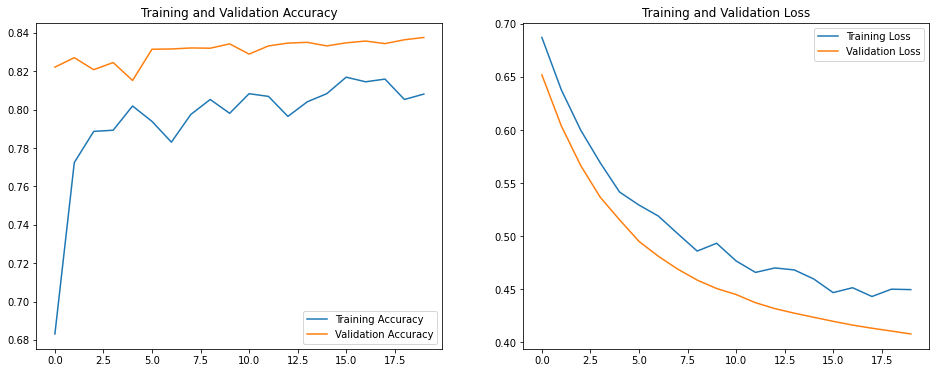

In [55]:
show_history(model.history)

In [61]:
model.load_weights('/tmp/tmp2wd0fep2/deepmoji-checkpoint-5e92f31c-5220-4c7f-a1e9-edcf0324780b.hdf5')
model.evaluate(deepmoji_x_test_full, y_test, verbose=1)

25000/25000 [==============================] - 318s 13ms/step


[0.40872070934295657, 0.8377199769020081]

Обучение проводилось за 20 эпох и точность классификатора составила 83.77%, что меньше, чем мы получали ранее. Однако, стоит заметить по графикам, что здесь нет переобучения: ошибка падает с кажой эпохой, а точность растёт. Это значит, что обучение можно продлить и до 1000 эпох, и тогда, вероятно, точность составит >90%.